In [ ]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [1]:
# !unzip archive.zip -d archive/

In [ ]:
import tensorflow as tf

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "archive/seg_train/seg_train",
    image_size=(80, 80),   # resize all images to 150x150
    batch_size=32
)

# Testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "archive/seg_test/seg_test",
    image_size=(80, 80),
    batch_size=32
)

# Normalize pixel values (0-255 -> 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
import pandas as pd

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
img_size = (80,80)
batch_size = 15000  # big enough to load all images at once

datagen = ImageDataGenerator(rescale=1./255)

# Training data
train_generator = datagen.flow_from_directory(
    "archive/seg_train/seg_train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Testing data
test_generator = datagen.flow_from_directory(
    "archive/seg_test/seg_test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Extract arrays
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
X_train shape: (14034, 80, 80, 3)
y_train shape: (14034, 6)
X_test shape: (3000, 80, 80, 3)
y_test shape: (3000, 6)


In [ ]:
import matplotlib.pyplot as plt

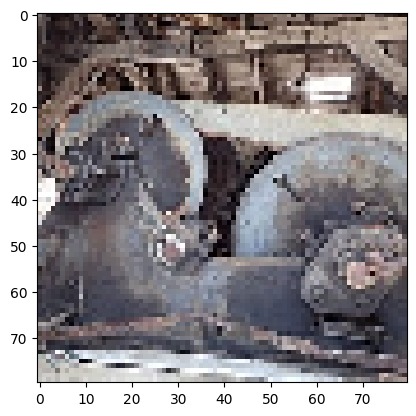

In [ ]:
plt.imshow(X_train[2])

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
num_classes = 6

2

In [ ]:
num_classes = y_train.shape[1]   # number of columns = classes
print("Number of classes:", num_classes)

Number of classes: 6


In [ ]:
X_train[0].shape

(80, 80, 3)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 80, 80, 3)
X_test = X_test.reshape(X_test.shape[0], 80, 80, 3)

In [ ]:
X_train.shape[1:]

(80, 80, 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# --- Convolutional Block 1 ---
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(80, 80, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# --- Convolutional Block 2 ---
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# --- Convolutional Block 3 ---
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# --- Convolutional Block 4 ---
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# --- Dense Layers ---
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# --- Output Layer ---
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,062,662 (7.87 MB)

 Trainable params: 2,061,702 (7.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=20, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.3236 - loss: 2.2287 - val_accuracy: 0.2457 - val_loss: 10.3357
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4105 - loss: 1.4445 - val_accuracy: 0.3593 - val_loss: 4.5626
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4939 - loss: 1.2354 - val_accuracy: 0.4940 - val_loss: 1.1860
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5645 - loss: 1.0784 - val_accuracy: 0.5733 - val_loss: 1.4512
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6193 - loss: 0.9806 - val_accuracy: 0.7057 - val_loss: 0.8577
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6414 - loss: 0.9571 - val_accuracy: 0.6320 - val_loss: 0.9411
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6655 - loss: 0.8625 - val_accuracy: 0.4847 - val_loss: 1.2885
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6864 - loss: 0.8551 - val

In [ ]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
y_test2 = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy is: ',accuracy_score(y_test2, y_pred))
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred))

accuracy is:  0.73
[[328   2   2   2  51  52]
 [ 14 411   1   9  25  14]
 [  7   1 232 128 185   0]
 [  8   0  21 311 185   0]
 [  7   0   3   6 494   0]
 [ 42   8   1   5  31 414]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       437
           1       0.97      0.87      0.92       474
           2       0.89      0.42      0.57       553
           3       0.67      0.59      0.63       525
           4       0.51      0.97      0.67       510
           5       0.86      0.83      0.84       501

    accuracy                           0.73      3000
   macro avg       0.79      0.74      0.73      3000
weighted avg       0.78      0.73      0.73      3000



In [ ]:
model.save("model.h5")

In [ ]:
import cv2
import numpy as np

# Define your class labels (must match training generator.class_indices order)
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def predict_image_cv2(img_path, target_size=(80, 80), model=model):
    """
    Predict class for a single image using OpenCV.

    Args:
        model      : Trained Keras model
        img_path   : Path to input image
        target_size: (width, height) same as training size

    Returns:
        predicted_class (str), confidence (float)
    """
    # Load image using OpenCV
    img = cv2.imread(img_path)             # BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Resize to model input size
    img = cv2.resize(img, target_size)

    # Normalize (0-255 → 0-1)
    img_array = img.astype("float32") / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    class_idx = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    return class_labels[class_idx], confidence

In [ ]:
predict_image_cv2('/content/snow glasier.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


('glacier', 0.9290068745613098)

In [ ]:
predict_image_cv2('/content/forest.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


('forest', 1.0)

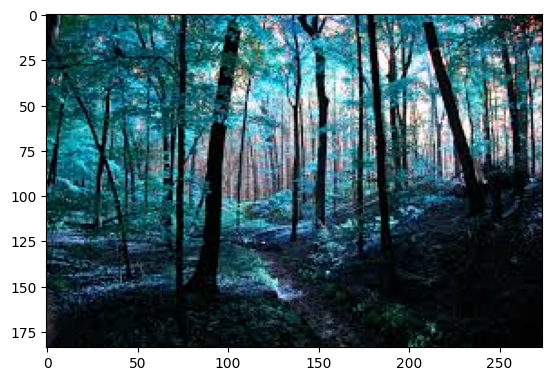

In [ ]:
plt.imshow(cv2.imread('/content/forest.jpg'))